In [25]:
# linear RNN, no synaptic learning, lqg control
import numpy as np
from rnn_lin import RNN
import matplotlib.pyplot as plt
import json
import torch
import control

## Loading Trained Weights

In [26]:
with open('SIN_lin_32_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [27]:
weight_history.keys()

dict_keys(['trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'weight_posneg'])

In [28]:
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])
weight_posneg = np.array(weight_history['weight_posneg'])
weight_matrix = np.abs(weight_matrix) * weight_posneg

## Perturbation (Sustained + Instant)

In [29]:
time_constant = 100 #ms
timestep = 10 #ms
time = 3000 #ms
num_inputs = 1
num_nodes = 32
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, None, None, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

In [30]:
# define inputs and targets
nt = 30
dt = network.timestep/network.time_const
T = np.arange(0, 30, dt)

# define inputs and targets
time_points = np.arange(300).reshape(-1, 1)
inputs = np.sin(time_points/60*np.pi)
targets = np.sin((time_points+1)/60*np.pi)
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

# define matrices
a = weight_matrix - np.eye(num_nodes)
b = np.eye(num_nodes)
c = np.eye(num_nodes)
d = np.zeros((num_nodes,num_nodes))
Bnoise = np.eye(num_nodes)
Q = np.eye(num_nodes) * 1
R = np.eye(num_nodes) * 0.01
W = np.eye(num_nodes) * 0.01
V = np.eye(num_nodes) * 0.001

# define noise
x_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=W, size=len(T))).T
y_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=V, size=len(T))).T
# x_noises[:,0:50] = 0
x_noises[:,70:80] += -1
# x_noises[:,60:150] = 0
x_noises[:,150:160] += -1
# x_noises[:,160:300] = 0

In [31]:
# from model
outputs, activations = network.simulate(time, torch.tensor(inputs).float(), input_weights) 

100%|██████████| 300/300 [00:00<00:00, 21947.45it/s]


In [32]:
# manual simulation without feedback, with noise
xs_nofb = []
ys_nofb = []
x = init_activations.copy()
u = 0 * init_activations.copy()

for i,t in enumerate(T):
    
    # output
    y = c @ x + d @ u

    # save
    xs_nofb.append(x.copy())
    ys_nofb.append(y.copy())

    # update x
    this_input = inputs[i] * input_weights.T
    process_noise = x_noises[:,i].reshape(-1,1)
    dx = dt * (a @ x + b @ u + this_input + Bnoise @ process_noise)
    x += dx

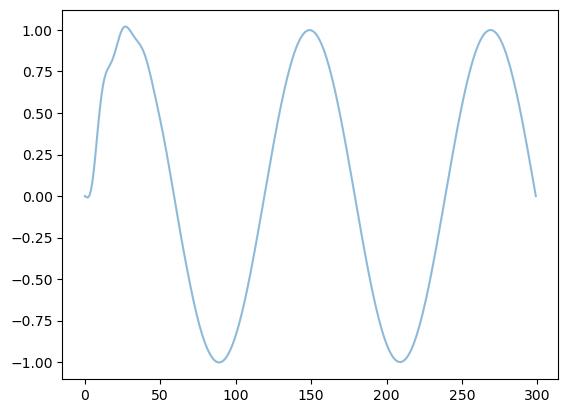

In [33]:
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='simu')

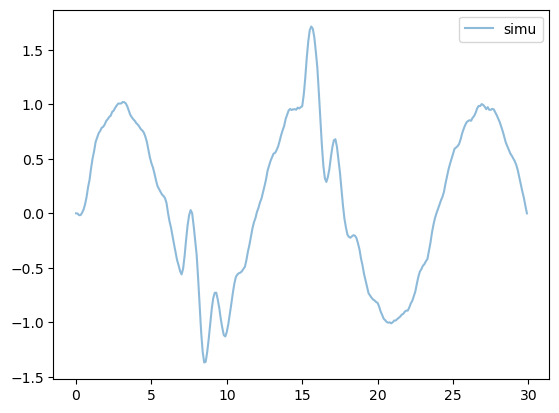

In [34]:
# check manual simulation
outs_nofb = [(output_weight_matrix @ y).item() for y in ys_nofb]
fig, ax = plt.subplots()
plt.plot(T, outs_nofb, alpha=0.5, label='simu')
plt.legend()

In [35]:
# target x
ideal_activations = activations.detach().numpy()

# Design State Feedback Controller
K, _, _ = control.lqr(a, b, Q, R)

# Design Kalman Filter
Kf, _, _ = control.lqe(a, Bnoise, c, W, V)

x = init_activations.copy()
xhat = init_activations.copy()
this_input = init_activations.copy()
u = 0 * init_activations.copy()
xs = []
ys = []
xhats = []
for i,t in enumerate(T):

    # Output
    measurement_noise = y_noises[:,i].reshape(-1,1)
    y = c @ x + d @ u + measurement_noise

    # Save
    xs.append(x.copy())
    ys.append(y.copy())

    # Kalman
    dxhat = dt * (a @ xhat + b @ u + this_input + Kf @ (y - c @ xhat - d @ u))
    xhat += dxhat
    xhats.append(xhat.copy())

    # LQR
    this_ideal_activation = ideal_activations[i,:].reshape(-1,1)
    u = -K @ (xhat - this_ideal_activation)

    # Update x
    this_input = inputs[i] * input_weights.T
    process_noise = x_noises[:,i].reshape(-1,1)
    dx = dt * (a @ x + b @ u + this_input + Bnoise @ process_noise)
    x += dx

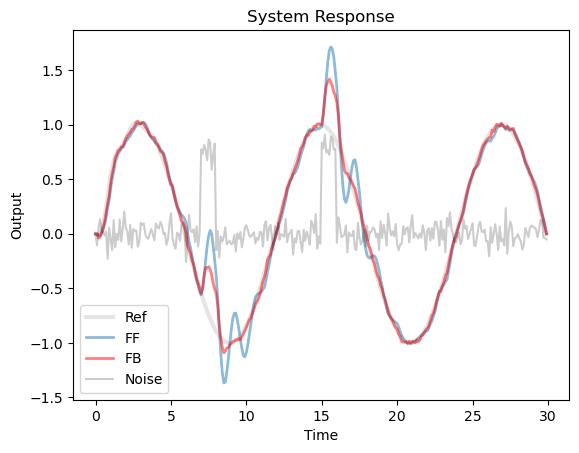

In [36]:
# Plot
outs = [(output_weight_matrix @ x).item() for x in xs]
noises_out = (output_weight_matrix @ x_noises).squeeze()
# outs_hat = [(output_weight_matrix @ x).item() for x in xhats]
# youts = [(output_weight_matrix @ y).item() for y in ys]

plt.plot(T, outputs.detach().numpy(), alpha=0.2, lw=3, color='gray', label='Ref')
plt.plot(T, outs_nofb, alpha=0.5, lw=2, label='FF')
plt.plot(T, outs, alpha=0.5, lw=2, color='r', label='FB')
plt.plot(T, noises_out, alpha=0.2, color='black', label='Noise')
# plt.plot(T, outs_hat, alpha=0.5, label='hat')
# plt.plot(T, youts, alpha=0.5, label='y')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response')
plt.legend()
plt.savefig("fig/SIN_lin_noise.png")